<a href="https://colab.research.google.com/github/purvamarkam/ML_LAB/blob/main/Assignment8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

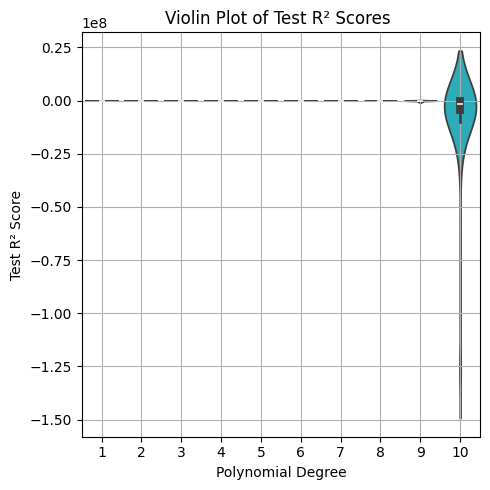

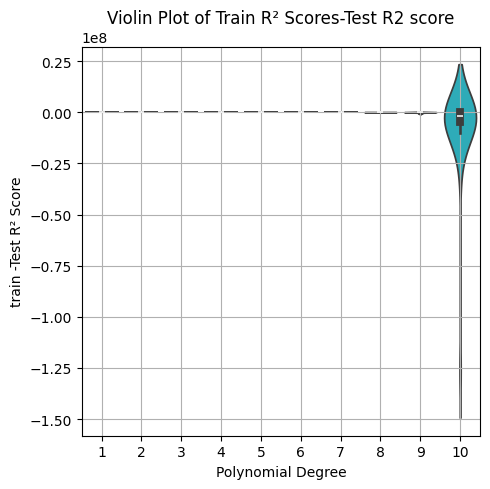

Degree 1: Avg CV R² = 0.6455
Degree 2: Avg CV R² = 0.5936
Degree 3: Avg CV R² = 0.8947
Degree 4: Avg CV R² = 0.9315
Degree 5: Avg CV R² = 0.9581
Degree 6: Avg CV R² = 0.6245
Degree 7: Avg CV R² = -1.0777
Degree 8: Avg CV R² = 0.6415
Degree 9: Avg CV R² = -68.2176
Degree 10: Avg CV R² = -356.3498

🎯 Best polynomial degree (based on CV): 5
✅ Final model of degree 5 trained on the 20-point sample.
✅ Lasso (L1) R² on test set: 0.9964
✅ Ridge (L2) R² on test set: 0.9965


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline

data = pd.read_csv('polynomial_regression.csv')
x = data[['x']]
y = data['y']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_samples = [x_train.sample(n=20, replace=True, random_state=i) for i in range(30)]
y_samples = [y_train.loc[sample.index] for sample in x_samples]

results = []
for i in range(30):
    x_sample = x_samples[i]
    y_sample = y_samples[i]

    sample_result = {"sample": i + 1}

    for degree in range(1, 11):
        poly = PolynomialFeatures(degree=degree)
        x_sample_poly = poly.fit_transform(x_sample)
        x_test_poly = poly.transform(x_test)

        model = LinearRegression()
        model.fit(x_sample_poly, y_sample)

        y_train_pred = model.predict(x_sample_poly)
        y_test_pred = model.predict(x_test_poly)

        train_r2 = r2_score(y_sample, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        sample_result[f"train_r2_deg{degree}"] = train_r2
        sample_result[f"test_r2_deg{degree}"] = test_r2

    results.append(sample_result)

results_df = pd.DataFrame(results)


test_r2_values = []

for degree in range(1, 11):
    col = f'test_r2_deg{degree}'
    test_r2_values.append(results_df[col].values)


plt.figure(figsize=(5, 5))
sns.violinplot(data=test_r2_values)
plt.xticks(ticks=range(10), labels=range(1, 11))
plt.xlabel("Polynomial Degree")
plt.ylabel("Test R² Score")
plt.title("Violin Plot of Test R² Scores ")
plt.grid(True)
plt.tight_layout()
plt.show()

train_test_r2_values = []

for degree in range(1, 11):
    train_col = f'train_r2_deg{degree}'
    test_col = f'test_r2_deg{degree}'
    diff = results_df[test_col] - results_df[train_col]
    train_test_r2_values.append(diff.values)

plt.figure(figsize=(5, 5))
sns.violinplot(data=train_test_r2_values)
plt.xticks(ticks=range(10), labels=range(1, 11))
plt.xlabel("Polynomial Degree")
plt.ylabel("train -Test R² Score")
plt.title("Violin Plot of Train R² Scores-Test R2 score")
plt.grid(True)
plt.tight_layout()
plt.show()


x_sample = x_train.sample(n=20, random_state=0)
y_sample = y_train.loc[x_sample.index]

# Step 2: Convert to NumPy arrays
x_sample_np = x_sample.to_numpy()
y_sample_np = y_sample.to_numpy()

# Step 3: 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
avg_r2_per_degree = []

for degree in range(1, 11):
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x_sample_np)

    fold_r2 = []

    for train_idx, val_idx in kf.split(x_poly):
        x_train_fold, x_val_fold = x_poly[train_idx], x_poly[val_idx]
        y_train_fold, y_val_fold = y_sample_np[train_idx], y_sample_np[val_idx]

        model = LinearRegression()
        model.fit(x_train_fold, y_train_fold)

        y_val_pred = model.predict(x_val_fold)
        fold_r2.append(r2_score(y_val_fold, y_val_pred))

    avg_r2 = np.mean(fold_r2)
    avg_r2_per_degree.append(avg_r2)
    print(f"Degree {degree}: Avg CV R² = {avg_r2:.4f}")
best_degree = np.argmax(avg_r2_per_degree) + 1
print(f"\n🎯 Best polynomial degree (based on CV): {best_degree}")

# Assume best_degree was found from part (a)
poly = PolynomialFeatures(degree=best_degree)
x_sample_poly = poly.fit_transform(x_sample)  # using the original x_sample (20 points)

model = LinearRegression()
model.fit(x_sample_poly, y_sample)

print(f"✅ Final model of degree {best_degree} trained on the 20-point sample.")
x_test_poly = poly.transform(x_test)

# Step 2: Predict using the trained model
y_test_pred = model.predict(x_test_poly)

# Step 3: Measure accuracy on the test set
from sklearn.preprocessing import StandardScaler

degree = 5  # Based on previous cross-validation

# L1 Regularization (Lasso) with standardization
lasso_model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=degree),
    LassoCV(cv=10, random_state=42)
)
lasso_model.fit(x_train, y_train)
y_test_pred_lasso = lasso_model.predict(x_test)
r2_lasso = r2_score(y_test, y_test_pred_lasso)

# L2 Regularization (Ridge) with standardization
ridge_model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=degree),
    RidgeCV(cv=10)
)
ridge_model.fit(x_train, y_train)
y_test_pred_ridge = ridge_model.predict(x_test)
r2_ridge = r2_score(y_test, y_test_pred_ridge)

# Print results
print(f"✅ Lasso (L1) R² on test set: {r2_lasso:.4f}")
print(f"✅ Ridge (L2) R² on test set: {r2_ridge:.4f}")